In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
import re
import numpy as np
import networkx as nx
import obonet as obo
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
from fuzzywuzzy import fuzz, process
import warnings
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection
import random as rn
import os

In [2]:
class GoData:
    """Class to load GO data and perform GO enrichment analysis.
    """
    def __init__(self, ontpath, taxid=9606, debug=None, assoc_source='ncbi', assoc_file=None):
        """Initialize the GoData object.
        Args:
            ontpath (str): Path to the ontology file. Can be a local path or a URL.
            taxid (int): NCBI Taxonomy ID of the species to use. Default is 9606 (human).
            debug (GoData): A previous GoData object to use for debugging. Default is None.
            associations (str): Path to the gene2go file. Can be a local path or a URL. Default is None.
            
        Returns:
            GoData: A GoData object.
        """
        assert assoc_source in ['mygene', 'ncbi', 'file'], "assoc_source must be one of ['mygene', 'goatools', 'file']"
        if assoc_source == 'file':
            assert assoc_file is not None, "assoc_file must be provided if assoc_source is 'file'"
        
        self.__ontpath = ontpath
        self.__taxid = taxid
        taxonomy_dict = {9606: 'Human', 10090: 'Mouse', 10116: 'Rat', 7227: 'Fruit fly', 
                    3702: 'Arabidopsis', 562: 'E. coli', 4932: 'S. cerevisiae', 
                    6239: 'C. elegans', 7955: 'Zebrafish', 9031: 'Chicken'}
        try:
            self.__species = taxonomy_dict[self.__taxid]
        except KeyError:
            warnings.warn("taxid not one of "+", ".join(taxonomy_dict.values()) +". Defaulting to species=human for GO Enrichment" , UserWarning)
            self.__species = "Human"
        self.BP = 'GO:0008150'
        self.CC = 'GO:0005575'
        self.MF = 'GO:0003674'

        # debug allows you to load a previous GoData object to update functions without reloading the data
        if debug is not None:
            self.go = debug.go
            self.id_to_name = debug.id_to_name
            self.name_to_id = debug.name_to_id
            self.geneid2go = debug.geneid2go
            self.go2geneid = debug.go2geneid
            self.assoc_file = debug.assoc_file
            self.assoc_source = debug.assoc_source
        else:
        # Ontology
            self.go = obo.read_obo(ontpath)
            self.id_to_name = {id_: data.get('name') for id_, data in self.go.nodes(data=True)}
            self.name_to_id = {data.get('name'): id_ for id_, data in self.go.nodes(data=True)}
            # Associations
            self.get_associations(assoc_source, assoc_file, taxid=taxid)
            
    def get_associations(self, assoc_source='ncbi', assoc_file=None, taxid=None):
        self.assoc_source = assoc_source
        self.assoc_file = assoc_file
        if self.assoc_source == 'file':
            assert assoc_file is not None, "assoc_file must be provided if assoc_source is 'file'"
        if self.assoc_source == 'mygene':
            raise(NotImplementedError)
            #geneid2go, go2geneid = self._map_using_mygene(gene_list, self.id_type)
        elif self.assoc_source == 'ncbi':
            geneid2go, go2geneid =  self._map_using_ncbi(taxid=taxid)
        elif self.assoc_source == 'file':
            raise(NotImplementedError)
            #geneid2go, go2geneid =  self._map_using_file(id_type=self.id_type)
        self.geneid2go = geneid2go
        self.go2geneid = go2geneid
    
    def _reverse_dict_of_sets(self, d):
        result = defaultdict(set)
        for k in d.keys():
            for v in d[k]:
                result[v].add(k)
        return result        

    def _map_using_ncbi(self, taxid=9606):
        if taxid is None:
            warnings.warn("taxid not provided. Defaulting to taxid=9606" , UserWarning)
            taxid = 9606
        gene2go = download_ncbi_associations()
        geneid2go = Gene2GoReader(gene2go, taxids=[taxid]).get_id2gos_nss(taxid=taxid)
        go2geneid = self._reverse_dict_of_sets(geneid2go)
        return geneid2go, go2geneid
    
    def get_subterms(self, node):
        """Get the direct subterms of a GO term, where subterms are represented as parents in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the subterms
        """
        subterm = []
        for parent, _ , _ in self.go.in_edges(node, keys=True):
            subterm.append(parent)
        return subterm

    def get_superterms(self, node):
        """Get the direct superterms of a GO term, where superterms are represented as children in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the superterms
        """
        superterm = []
        for _ , child, _ in self.go.out_edges(node, keys=True):
            superterm.append(child)
        return superterm

    def get_all_superterms(self, node):
        """Get all the superterms of a GO term, where superterms are represented as children in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the superterms
        """
        ancestors = [superterm for superterm in nx.descendants(self.go, node)]
        return ancestors

    def get_all_subterms(self, node):
        """Get all the subterms of a GO term, where subterms are represented as parents in the ontology.

        Args:
            node (str): The GO id of the term

        Returns:
            list: The GO ids of the subterms
        """
        descendents = [superterm for superterm in nx.ancestors(self.go, node)]
        return descendents
    
    def get_associated_genes(self, goID):
        """Get all the genes associated with a GO term, including genes associated with subterms.

        Args:
            goID (str): The GO id of the term

        Returns:
            set: The gene ids associated with the GO term
        """
        all_genes = self.go2geneid[goID]
        subterms = self.get_all_subterms(goID)
        for goid in subterms:
            all_genes = all_genes.union(self.go2geneid[goid])
            
        return all_genes
    
    def to_name(self, goID):
        """Convert a GO id to a GO name.

        Args:
            goID (str): The GO id of the term

        Returns:
            str: The GO name of the term
        """
        if type(goID) == int:
            goID = self.to_id(goID)
        assert goID in self.go.nodes, "ID "+ goID +" is not in the ontology."
        return self.id_to_name[goID]
    
    def to_id(self, name):
        """Convert a GO name or numerical suffix to a GO id. Where the name does not exactly match a GO term, 
        a list of possible matches is given in the error message.
        
        Args:
            name (str or int): The GO name or numerical suffix of the term
            
        Returns:
            str: The GO id of the term
        """
        if type(name) == int:
            id_ = "GO:" + "0" * (7-len(str(name))) + str(name)
            assert id_ in self.go.nodes, "ID "+id_+" is not in the ontology."
            return id_
        elif type(name) == str:
            assert name in self.name_to_id.keys(), name+" is not in the ontology. Maybe you meant (one of):\n" + "\n".join(self.get_fuzzy_go_terms(name))
            return self.name_to_id[name]
        
    def get_fuzzy_go_terms(self, term, max_terms=10):
        """Get a list of GO terms that are similar to the input term, using fuzzy matching.

        Args:
            term (str): The GO term to match
            max_terms (int, optional): The maximum number of terms to return. Defaults to 10.

        Returns:
            list: A list of GO terms that are similar to the input term
        """
        results = process.extract(term, self.name_to_id.keys(), scorer=fuzz.token_sort_ratio, limit=max_terms)
        for term, score in results:
            if score == 100:
                return [term]
        return [match[0] for match in results]
    
    def plot_go_counts(self, terms, min_gene=100, max_gene=20000, plot_title="None"):
        """Plot the number of genes associated with a GO term, and its subterms.
        
        Args:
            terms (str or list): The GO term or list of GO terms to plot
            min_gene (int, optional): The minimum number of genes to include in the plot. Defaults to 100.
            max_gene (int, optional): The maximum number of genes to include in the plot. Defaults to 20000.
            plot_title (str, optional): The title of the plot. Defaults to "None".
        
        Returns:
            None        
        """
        if type(terms) == str:
            root_term = terms
            terms = self.get_subterms(terms)
        else:
            if type(terms) == set:
                terms = list(terms)
            root_term = ""
        term_counts = {term:len(self.get_associated_genes(term)) for term in terms}
        keep_counts = {term:term_counts[term] for term in terms if (term_counts[term] >= min_gene) & (term_counts[term] <= max_gene)}
        if len(keep_counts) == 0:
            print("All terms excluded!\nMaximum count: ", max(term_counts.values()), 
                    "\nMinimum count: ", min(term_counts.values()))
            return
        print("Terms excluded:", len(terms) - len(keep_counts))
        plot_df = pd.DataFrame({'term':keep_counts.keys(), 'count':keep_counts.values()})
        plot_df.sort_values(by="count", ascending=False, inplace=True)
        _ = plt.figure(figsize=(15, 4))
        ax = plt.gca()
        sns.barplot(data=plot_df, x='term', y='count', ax=ax)
        ax.set_xticklabels([self.to_name(term) for term in plot_df["term"]], rotation=90)
        if root_term != "":
            ax.set_title(self.to_name(root_term))
        elif plot_title is not None:
            ax.set_title(plot_title)
        return ax
    
    def get_go_term_subset(self, root_term, min_size=100, max_size=1000):
        """Get a subset of GO terms that are within a certain size range, and are descendants of a root term.

        Args:
            root_term (str): The GO term to use as the root of the subset
            min_size (int, optional): The lower bound of the size range. Defaults to 100.
            max_size (int, optional): The upper bound of the size range. Defaults to 1000.

        Returns:
            set: The set of GO terms that are within the size range, and are descendants of the root term
        """
        stack = [root_term]
        visited_nodes = set()
        final_terms = set()
        # perform a modified depth first search with min and max size constraints
        while stack:
            term = stack.pop()
            # check if we have already visited this node, as graph may have cycles
            if term in visited_nodes:
                continue
            visited_nodes.add(term)
            # check if the term is within the size constraints
            term_size = len(self.get_associated_genes(term))
            if term_size < min_size:
                continue 
            # if the term is within the size constraints, add it to the final set
            if term_size >= min_size and term_size <= max_size:
                final_terms.add(term)
            # if the term is too large, add its subterms to the stack
            else:
                subterms = self.get_subterms(term)
                for subterm in subterms:
                    if subterm not in visited_nodes:
                        stack.append(subterm)
        # remove any terms that are subterms of other terms in the final set
        subgraph = self.go.subgraph(final_terms)
        remove_nodes = [node for node in subgraph.nodes if len(list(subgraph.predecessors(node))) > 0]
        final_terms = [term for term in final_terms if term not in remove_nodes]
        return final_terms
    
    def go_enrichment(self, gene_list, terms, background_genes=None, plot=False):
        """Perform a GO enrichment analysis on a list of genes.

        Args:
            gene_list (list): The list of genes to perform the enrichment analysis on
            terms (str or list): The GO term or list of GO terms to perform the enrichment analysis on
            background_genes (list, optional): The list of genes to use as the background. Defaults to None.
            plot (bool, optional): Whether to plot the results. Defaults to False.

        Returns:
            pandas.DataFrame: A dataframe containing the results of the enrichment analysis
        """
        # subset gene_list to those present in the ontology
        if background_genes is not None:
            if type(background_genes) == list:
                background_genes = set(background_genes)
            gene_list_present = [gene for gene in list(set(gene_list).intersection(background_genes)) if gene in self.geneid2go.keys()]
        else:
            gene_list_present = [gene for gene in gene_list if gene in self.geneid2go.keys()]
        
        if len(gene_list) - len(gene_list_present) >0:
            print("Warning: ", len(gene_list) - len(gene_list_present), " genes not in the ontology and/or background genes.")
        gene_list = gene_list_present
        #process the term list
        if type(terms) == str:
            terms = [terms]
        # Get the genes associated with each term
        term_genes = {term: self.get_associated_genes(term) for term in terms}
        if background_genes is not None:
            if type(background_genes) == list:
                background_genes = set(background_genes)
            term_genes = {term: term_genes[term].intersection(background_genes) for term in terms}
        # Count the number of genes in each term
        term_gene_counts = {term: len(term_genes[term]) for term in terms}
        # Count the number of genes in the gene set that are associated with each term
        term_gene_set_counts = {term: len(set(gene_list).intersection(term_genes[term])) for term in terms}
        # Calculate the p-value for each term using the Fisher's exact test
        p_values = {}
        expected = {}
        for term in terms:
            term_p, term_e = self._fisher_test(background_genes, term_gene_counts[term], term_gene_set_counts[term], gene_list)
            p_values[term] = term_p
            expected[term] = term_e
        
        # Sort the terms by p-value in ascending order
        sorted_terms = sorted(p_values, key=p_values.get)
        if len(sorted_terms) == 1:
            enriched_terms = pd.DataFrame({'Term': sorted_terms, 'P-value': [p_values[sorted_terms[0]]]})
        else:
            enriched_terms = pd.DataFrame({'Term': sorted_terms, 'P-value': [p_values[term] for term in sorted_terms]})
        enriched_terms["Term_size"] = enriched_terms.Term.apply(lambda x: term_gene_counts[x])
        enriched_terms["Intersection"] = enriched_terms.Term.apply(lambda x: term_gene_set_counts[x])
        enriched_terms["Expected"] = enriched_terms.Term.apply(lambda x: expected[x])
        if plot:
            self._plot_enrichment(enriched_terms, expected, p_values, terms, sorted_terms) 
        
        return enriched_terms
    
    def _fisher_test(self,  background_genes, gene_count, gene_set_count, gene_list):
        """Perform a Fisher's exact test on a gene set.

        Args:
            background_genes (list): The list of genes to use as the background
            gene_count (int): The number of genes associated with the term
            gene_set_count (int): The number of genes in the gene set that are associated with the term
            gene_list (list): The list of genes to perform the enrichment analysis on

        Returns:
            tuple: The p-value and expected value of the Fisher's exact test
        """
        if background_genes is not None:
            N = len(set(self.geneid2go.keys()).intersection(background_genes))
        else:
            N = len(self.geneid2go) # Total number of genes
        a = gene_set_count # Number of genes in the gene set that are associated with the term
        b = len(gene_list) - a # Number of genes in the gene set that are not associated with the term
        c = gene_count - a # Number of genes not in the gene set that are associated with the term
        d = N - a - b - c # Number of genes not in the gene set that are not associated with the term
        p_val = fisher_exact([[a, b], [c, d]])[1]
        expected = (gene_count/N) * len(gene_list)
        return p_val, expected
    
    def _plot_enrichment(self, enriched_terms, expected, p_values, terms, sorted_terms):
        """Plot the results of a GO enrichment analysis.

        Args:
            enriched_terms (pandas.DataFrame): The dataframe containing the results of the enrichment analysis
            expected (dict): The expected value of the number of term associated genes in the gene set
            p_values (dict): The p-value of enrichment for each term
            terms (list): The list of terms that were tested
            sorted_terms (list): The list of terms sorted by p-value
            
        Returns:
            None
        """
        plot_data = enriched_terms.loc[:, ("Term", "Intersection")]
        plot_data.columns = ["Term", "#Genes"]
        plot_data["Color"] = "Observed"
        plot_data = pd.concat([plot_data, pd.DataFrame({"Term": expected.keys(), "#Genes":expected.values(), "Color":"Expected"})])
        _ = plt.figure(figsize=(10, 5))
        plot_data['Term'] = plot_data.Term.apply(self.to_name)
        sns.barplot(data=plot_data, x="Term", y="#Genes", hue="Color", alpha=0.7, hue_order=["Expected", "Observed"], palette=['grey', 'blue'])
        ax = plt.gca()
        for i, p in enumerate(ax.patches):
            if i >= len(terms):
                text = f"{p_values[sorted_terms[i-len(terms)]]:.1e}"
                ax.text(p.get_x() + p.get_width()/2., p.get_height(), text, rotation=90,
                    fontsize=10, color='black', ha='center', va='bottom')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        

In [3]:
go_path = 'https://current.geneontology.org/ontology/go.obo'

In [4]:
go_data = GoData(ontpath = 'http://purl.obolibrary.org/obo/go.obo', debug=None)


  EXISTS: gene2go
HMS:0:01:26.372947 347,845 annotations, 20,780 genes, 18,718 GOs, 1 taxids READ: gene2go 


In [5]:
go_data.get_associations()

/tmp/ipykernel_3154087/1022444022.py:75: UserWarning: taxid not provided. Defaulting to taxid=9606
  warnings.warn("taxid not provided. Defaulting to taxid=9606" , UserWarning)


  EXISTS: gene2go
HMS:0:01:11.533848 347,845 annotations, 20,780 genes, 18,718 GOs, 1 taxids READ: gene2go 


Goal: get a diverse range of GO terms with between 150 and 500 genes associated. 

How: I think the depth and breadth first searches will give the same ultimate result - so use the existing depth first search method.

In [6]:
bp_terms = go_data.get_go_term_subset('GO:0008150', min_size=200, max_size=300)
print(len(bp_terms))

230


In [7]:
cc_terms = go_data.get_go_term_subset('GO:0005575', min_size=200, max_size=300)
print(len(cc_terms))

44


In [8]:
mf_terms = go_data.get_go_term_subset('GO:0003674', min_size=200, max_size=300)
print(len(mf_terms))

54


In [2]:
bp_genesets = {term: go_data.get_associated_genes(term) for term in bp_terms}
cc_genesets = {term: go_data.get_associated_genes(term) for term in cc_terms}
mf_genesets = {term: go_data.get_associated_genes(term) for term in mf_terms}
genesets = {**bp_genesets, **cc_genesets, **mf_genesets}

NameError: name 'bp_terms' is not defined

In [1]:
bp_genesets

NameError: name 'bp_genesets' is not defined

In [18]:
from neteval.data_import_export_tools import write_node_sets

In [19]:
write_node_sets(genesets, '/cellar/users/snwright/Data/NetColocTest/Reference/go.genesets')

Will need to find some way to exclude sibling terms.

## Measure the ontology distance between terms
Expectation: distance between different branches will be high -> do within each branch separately  
May need to make an undirected version of the graph.

In [14]:
G = go_data.go.to_undirected()

In [57]:
def plot_go_distances(term_list, G):
    dists = []
    for t in tqdm(term_list):
        for t2 in term_list:
            if t != t2:
                dists.append(nx.shortest_path_length(G, source=t, target=t2, weight=None, method='dijkstra'))
    return dists

In [62]:
bp_dist = plot_go_distances(bp_terms, G)
cc_dist = plot_go_distances(cc_terms, G)
mf_dist = plot_go_distances(mf_terms, G)

100%|██████████| 54/54 [00:00<00:00, 110.47it/s]


In [106]:
np.mean(bp_dist) + np.std(bp_dist)*1.5

8.136680888459592

In [105]:
np.mean(mf_dist) + np.std(mf_dist)*1.5

8.091173416749623

In [104]:
np.mean(cc_dist) + np.std(cc_dist)*1.5

7.022483169767417

In [98]:
np.percentile(np.array(bp_dist), [0.1, 0.5, 0.9])

array([2., 2., 3.])

In [71]:
all_dist = plot_go_distances(list(genesets.keys()), G)

100%|██████████| 297/297 [00:40<00:00,  7.29it/s]


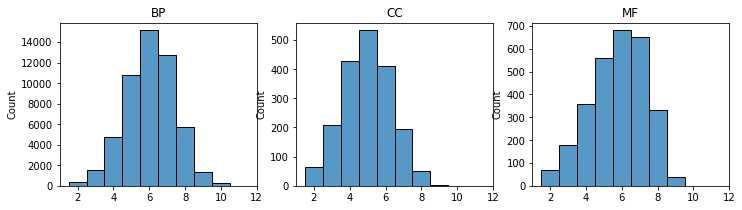

In [67]:
_, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex=True, sharey=False)
sns.histplot(bp_dist, bins=[i for i in range(12)], ax=ax1, discrete=True)
sns.histplot(cc_dist, bins=[i for i in range(12)], ax=ax2, discrete=True)
sns.histplot(mf_dist, bins=[i for i in range(12)], ax=ax3, discrete=True)
for i, ax in enumerate([ax1,ax2, ax3]):
    ax.set_xticks([2,4,6,8,10,12])
    ax.set_title(['BP', 'CC', 'MF'][i])

In [56]:
def get_distal_go_terms(G, term_list, max_pairs_per_term=2, min_distance=8):
    rn.shuffle(term_list)
    term_pairs = defaultdict(list)
    for t in tqdm(term_list):
        for t2 in term_list:
            if (len(term_pairs[t]) < max_pairs_per_term) and (len(term_pairs[t2]) < max_pairs_per_term):
                if nx.shortest_path_length(G, source=t, target=t2, weight=None, method='dijkstra') >= min_distance:
                    term_pairs[t].append(t2)
                    term_pairs[t2].append(t)
            elif term_pairs[t] == max_pairs_per_term:
                break            
    all_pairs = []
    for k, p in term_pairs.items():
        if len(p) > 0:
            for term in p:
                all_pairs.append(sorted((k, term)))
    cross_pairs = pd.DataFrame(all_pairs, columns=['TraitR', 'TraitC']).drop_duplicates()
    return cross_pairs

In [86]:
bp_cross_pairs = get_distal_go_terms(G, bp_terms, 2, 8)
cc_cross_pairs = get_distal_go_terms(G, cc_terms, 2, 7)
mf_cross_pairs = get_distal_go_terms(G, mf_terms, 2, 8)

100%|██████████| 54/54 [00:00<00:00, 395.67it/s]


In [87]:
all_cross_pairs= pd.concat([bp_cross_pairs, cc_cross_pairs, mf_cross_pairs])

In [91]:
all_cross_pairs.to_csv('/cellar/users/snwright/Data/NetColocTest/inputs/trait_pairs_cross_GO.txt', sep='\t', index=False)

In [118]:
all_cross_pairs.head()

,TraitR,TraitC
0,GO:0042113,GO:0050821
1,GO:0045333,GO:0050821
3,GO:0009152,GO:0042113
4,GO:0005125,GO:0009152
5,GO:0005125,GO:0042098


In [122]:
for i, pair in all_cross_pairs.iterrows():
    rare1 = rn.sample(list(genesets[pair.TraitR]), 50)
    common1 = rn.sample(list(genesets[pair.TraitR]), 100)
    rare2 = rn.sample(list(genesets[pair.TraitC]), 100)
    common2 = rn.sample(list(genesets[pair.TraitC]), 50)
    traits = [pair.TraitR, pair.TraitR, pair.TraitC, pair.TraitC]
    suffix = ['_RV.txt', '_CV.txt', '_RV.txt', '_CV.txt']
    for i, geneset in enumerate([rare1, common1, rare2, common2]):
        with open(os.path.join('/cellar/users/snwright/Data/NetColocTest/inputs/GO', traits[i]+suffix[i]), 'w') as out:
            out.write('\n'.join([str(x) for x in geneset]))
